In [11]:
import uproot3
import ROOT as r
import mplhep
import matplotlib.pyplot as plt
import numpy as np
plt.style.use(mplhep.style.CMS)

In [15]:
rd = r.TFile.Open('outfiles/Run3Summer22/fulllumi/fitDiagnosticsTest.root')

par_names = rd.Get('fit_s').floatParsFinal().contentsString().split(',')
par_names = [p for p in par_names if 'smear' in p or 'scale' in p  or 'eff' in p]
par_names
out = {}

for pn in par_names:
    out[pn] = {}
    out[pn]['val'] = round(rd.Get('fit_s').floatParsFinal().find(pn).getVal(), 3)
    out[pn]['unc'] = round(rd.Get('fit_s').floatParsFinal().find(pn).getError(), 3)
out

{'CMS_scale': {'val': -1.0, 'unc': 0.079},
 'CMS_smear': {'val': -1.0, 'unc': 0.215},
 'effSF': {'val': 1.161, 'unc': 0.276},
 'effSF_un': {'val': 0.868, 'unc': 0.468}}

In [16]:
import json
with open('outfiles/Run3Summer22/fulllumi//config.json') as cfg_file:
    cfg = json.load(cfg_file)

out['scale'] = {}
out['scale']['val'] = cfg['scale'] * out['CMS_scale']['val']  # * 1 (template shape)
out['scale']['unc'] = cfg['scale'] * out['CMS_scale']['unc']  # * 1 (template shape)

out['smear'] = {}
out['smear']['val'] = cfg['smear'] * out['CMS_smear']['val']  * 0.5  # (template shape)
out['smear']['unc'] = cfg['smear'] * out['CMS_smear']['unc']  * 0.5 # (template shape)

out

{'CMS_scale': {'val': -1.0, 'unc': 0.079},
 'CMS_smear': {'val': -1.0, 'unc': 0.215},
 'effSF': {'val': 1.161, 'unc': 0.276},
 'effSF_un': {'val': 0.868, 'unc': 0.468},
 'scale': {'val': -1.0, 'unc': 0.079},
 'smear': {'val': -0.05, 'unc': 0.010750000000000001}}

In [2]:
f = uproot3.open('outfiles/Run3Summer22/fulllumi/fitDiagnosticsTest.root')

In [3]:
f['shapes_fit_s/SinglePass'].keys()

[b'data;1',
 b'non;1',
 b'top;1',
 b'w;1',
 b'total;1',
 b'total_signal;1',
 b'total_background;1',
 b'total_covar;1']

In [4]:
def convTH1(TH1):
    vals = TH1.values
    edges = TH1.edges
    variances = TH1.variances
    vals = vals * np.diff(edges)
    variances = variances * np.diff(edges)
    return vals, edges, variances


def covnTGA(tgasym):
        # https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit/wiki/nonstandard
        # Rescale density by binwidth for actual value
        _binwidth = tgasym._fEXlow + tgasym._fEXhigh
        _x = tgasym._fX
        _y = tgasym._fY * _binwidth
        _xerrlo, _xerrhi = tgasym._fEXlow, tgasym._fEXhigh
        _yerrlo, _yerrhi = tgasym._fEYlow * _binwidth, tgasym._fEYhigh * _binwidth
        return _x, _y, [_yerrlo, _yerrhi], [_xerrlo, _xerrhi]
    
def covnTGATH1(tgasym):
        # https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit/wiki/nonstandard
        # Rescale density by binwidth for actual value
        _binwidth = tgasym._fEXlow + tgasym._fEXhigh
        _bins = np.r_[tgasym._fX - tgasym._fEXlow, tgasym._fX[-1] + tgasym._fEXlow[-1]]
        _x = tgasym._fX
        _y = tgasym._fY * _binwidth
        _xerrlo, _xerrhi = tgasym._fEXlow, tgasym._fEXhigh
        _yerrlo, _yerrhi = tgasym._fEYlow * _binwidth, tgasym._fEYhigh * _binwidth
        return _y, _bins, ((_yerrhi + _yerrlo)/2)**2
    
# convTH1(fd['shapes_fit_s/wsfPrimaryFail/qcd'])
# covnTGATH1(fd['shapes_fit_s'+'/wsfSecondaryFail/data'])

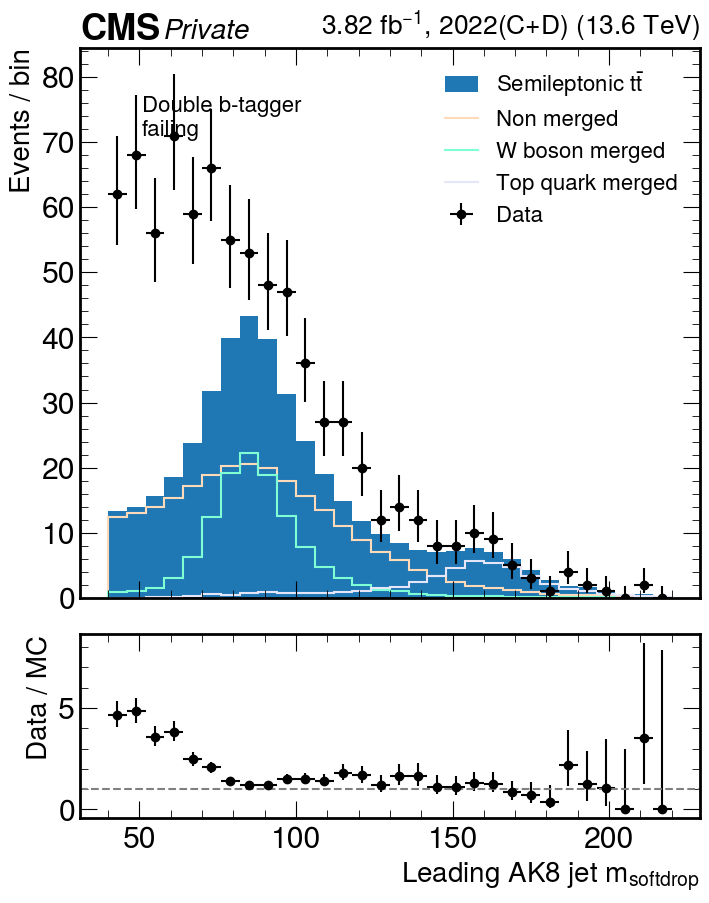

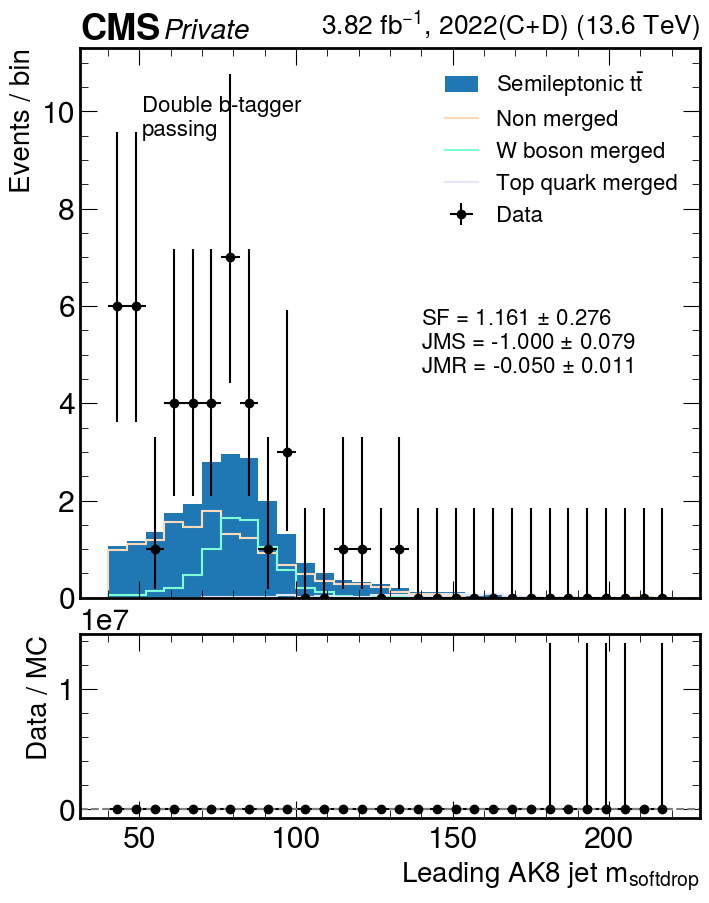

In [23]:
region = {
    "Fail" : "failing",
    "Pass" : "passing"
}

for reg in ['Fail', 'Pass']:

    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(8, 10), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)
    ax.set_ylabel("Events / bin")
    rax.set_ylabel("Data / MC")
    rax.set_xlabel(r"m$_{softdrop}$")
    ax.set_xlabel(" ")

    htot = convTH1(f['shapes_fit_s/Single{}/total'.format(reg)])
    mplhep.histplot(htot[0],
                    htot[1],
                    histtype="fill",
                    ax=ax,
                    label=r"Semileptonic $t\bar{t}$",)
    
    hs = []
    for key in ["non", "w", "top"]:
        h = convTH1(f['shapes_fit_s/Single{}/{}'.format(reg, key)])
        hs.append(h[0])
    mplhep.histplot(hs,
                    htot[1],
                    color=["peachpuff","aquamarine","lavender"],
                    ax=ax,
                   label=[
                        "Non merged",
                        "W boson merged",
                        "Top quark merged",
                    ],)
        
    tgo = covnTGA(f['shapes_fit_s/Single{}/data'.format(reg)])
    ax.errorbar(tgo[0], tgo[1], yerr=tgo[2], xerr=tgo[3], fmt='o', c='k', label=f"Data")

    from uncertainties import unumpy
    data = unumpy.uarray(tgo[1], tgo[2])
    mc =  unumpy.uarray(htot[0], htot[2])
    ratio = data/mc

    rax.errorbar(tgo[0], unumpy.nominal_values(ratio)[0], unumpy.std_devs(ratio), xerr=tgo[3], fmt='o', color='black', label='Data')

    rax.axhline(1, color='gray',ls='--')
    
    plt.text(0.1, 0.83, f"Double b-tagger\n{region[reg]}",
                    fontsize=16,
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    transform=ax.transAxes
                   )

    mplhep.cms.label(
        ax=ax, 
        data=True, 
        label="Private",
        year="2022(C+D)",
        lumi=f"{3820.82926407/1000:.2f}",
        com=13.6,
        fontsize=20,
    )
    
    if reg == "Pass":
        
        sfstr = ("SF = {:.3f} $\pm$ {:.3f}".format(out['effSF']['val'], out['effSF']['unc'])
         + "\nJMS = {:.3f} $\pm$ {:.3f}".format(out['scale']['val'], out['scale']['unc'])
         + "\nJMR = {:.3f} $\pm$ {:.3f}".format(out['smear']['val'], out['smear']['unc'])
        )
        
        plt.text(0.55, 0.4, sfstr,
                    fontsize=16,
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    transform=ax.transAxes
                   )

    ax.set_ylabel("Events / bin", fontsize=20)
    rax.set_ylabel("Data / MC", fontsize=20)
    rax.set_xlabel(r"Leading AK8 jet $m_{softdrop}$", fontsize=20)
    ax.set_xlabel(" ")

    ax.legend(loc='best', fontsize=16)